We consider the recovery of a sparse measure $m_{a,x} = \sum_{j=1}^s a_j \delta_{x_j}$ from 
$$
\Phi m_{a,x} = \int \phi(x) \mathrm{d}m_{a,x} = \sum_{j=1}^s a_j \phi(x_j).
$$
We consider the case where $\phi(x) = \left( \exp(-\sqrt{-1} 2\pi x k) \right)_{k=-f_c,\ldots, f_c }$.

Given $t= (t_i)_i$, define the Fourier operator $\Phi_t =\frac{1}{\sqrt{2f_c+1}} \left( \exp(-\sqrt{-1} 2\pi t_i k) \right)_{\substack{k=-f_c,\ldots, f_c \\ i=1,\ldots, n}} $
and its derivative
$\mathrm{d}\Phi_t =\frac{1}{\sqrt{2f_c+1}} \left(-\sqrt{-1} 2\pi  k \exp(-\sqrt{-1} 2\pi t_i k) \right)_{\substack{k=-f_c,\ldots, f_c \\ i=1,\ldots, n}} $

In [1]:
import numpy as np

#define operators
fc = 4
fq = np.arange(-fc, fc+1)
Phi = lambda t: np.exp(-2*np.pi*1j*fq[:,None]@t[None,:])/np.sqrt(2*fc+1)
dPhi = lambda t: (-2*np.pi*1j*fq[:,None])*np.exp(-2*np.pi*1j*fq[:,None]@t[None,:])/np.sqrt(2*fc+1)

Define the ground truth $a,x$ and observations $y = \Phi_x a$. We then plot the observation $\Phi^* y$ on a grid.

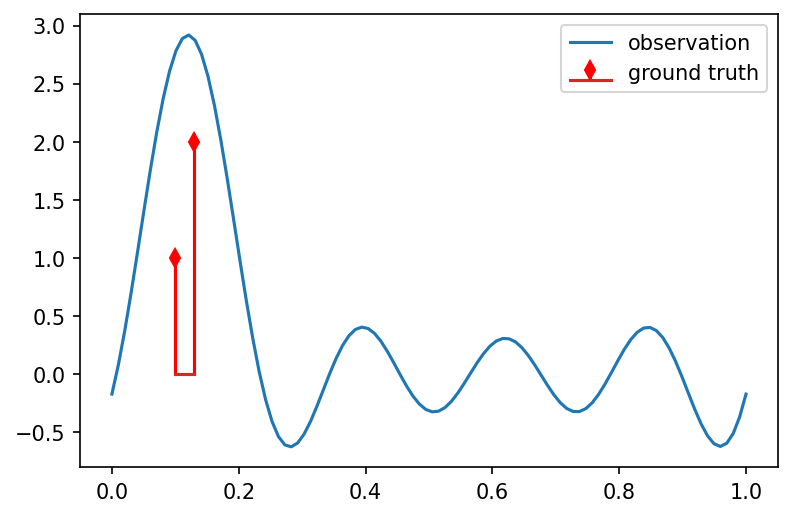

In [7]:
import matplotlib.pyplot as plt


#define ground truth
a = np.array([1,2])
x = np.array([0.1,0.13])
plt.figure(dpi=150)


plt.stem(x,a,'r', markerfmt=('rd'),label = 'ground truth')

#observation
y = Phi(x)@a
n = 100;
tgrid = np.linspace(0,1,n)
plt.plot(tgrid, np.real(np.conjugate(Phi(tgrid)).T@y) , label='observation')
plt.legend()

Recall that the candidate certificate can be used to analyse stability. It is defined as follows:
Let $\Gamma_x = [\Phi_x, \Phi^{(1)}_x]$, then 
$$
\eta = \Phi^* \left(\Gamma_x^{*,\dagger} \binom{\mathrm{sign}(a)}{0} \right) =  \Phi^* \Gamma_x (\Gamma_x^* \Gamma_x)^{-1} \binom{\mathrm{sign}(a)}{0}
$$
It is necessary that $\|\eta\|_\infty \leq 1$ for support stability to hold.

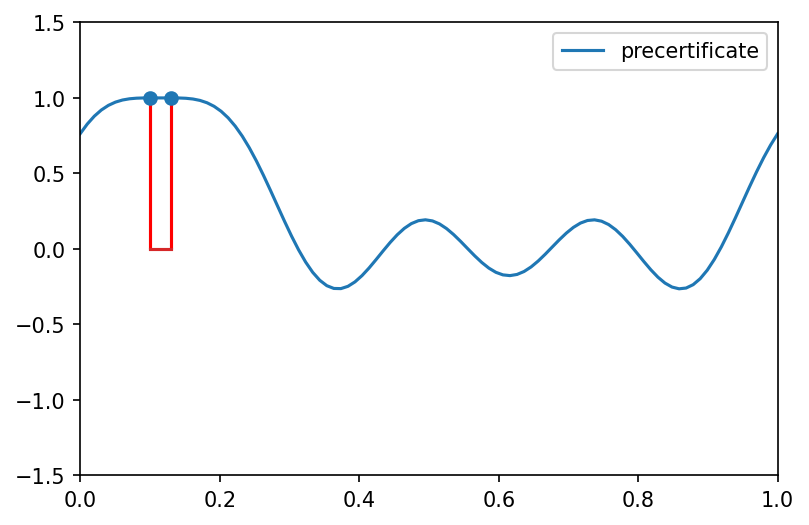

In [8]:
from numpy import linalg 


#compute the certificate on a grid
S = np.concatenate((np.sign(a), np.zeros_like(a)))
Gamma =  np.concatenate((Phi(x), dPhi(x)),1)
M = np.real(np.conjugate(Gamma).T@ Gamma)
coeffs = linalg.solve(M,S)

n = 100;
tgrid = np.linspace(0,1,n)
eta = np.real(np.conjugate(Phi(tgrid)).T@ (Gamma@coeffs))


#display
plt.figure(dpi=150)

plt.plot(tgrid,eta, label = 'precertificate')
plt.stem(x,np.sign(a), 'r')
plt.xlim(0,1)
plt.ylim(-1.5,1.5)
plt.legend()
plt.show()

The sliding Frank-Wolfe algorithm

In [4]:
from scipy import optimize

def sliding_frank_wolfe(Phi, dPhi, y, maxits,lam):
    Eta = lambda x0, x,a: np.real(np.conjugate( Phi(x0) ).T  @ ( y - Phi(x)@a ))/lam
    dEta = lambda x0, x,a: np.real(np.conjugate( dPhi(x0) ).T  @ ( y - Phi(x)@a ))/lam
    
    #A coarse grid on which to find argmax_x |eta_k(x)|
    n = 20
    xgrid = np.linspace(0,1,n)
    
    M = np.sum(np.abs(y)**2)/(2*lam)
    xvals = np.array([])
    avals = np.array([])
    for k in range(1,maxits):
        
        #find max_x |eta_k(x)| on the grid xgrid
        eta_k = Eta(xgrid, xvals,avals )
        idx = np.argmax( np.abs(  eta_k ) )
        xnew =  xgrid[ idx ]
        
        #check optimality max_x |eta_k(x)| <= 1
        if np.max( np.abs( eta_k[idx] ) )  <1+1e-5:
            break
        
        #with the starting point xnew, run BFGS on max_x |eta_k(x)|^2 
        mfun = lambda x: -linalg.norm( Eta(x, xvals,avals ))**2/2
        mgrad = lambda x: Eta(x, xvals,avals )*dEta(x,xvals,avals)
        R = optimize.minimize(mfun, np.array([xnew]), method='L-BFGS-B', jac=mgrad, options = { "maxiter" : 100})
        xnew = R.x[0]
       
        
        anew =  M * np.sign( Eta(np.array([xnew]),xvals, avals) )[0]
        
        #Add the new point xnew
        xvals = np.append( xvals, xnew )
        avals = np.append( avals * (1-2/(k+2)), 2/(k+2)*anew )

        
        #Run ISTA to optimise amplitudes
        X = np.real(np.conjugate( Phi(xvals) ).T@Phi(xvals))
        Xty = np.real(np.conjugate( Phi(xvals) ).T@ y)
        tau = 1/linalg.norm(X)
        for it in range(100):
            avals = avals - tau*X@avals + tau*Xty
            avals = np.sign(avals)*np.maximum(np.abs(avals)-tau*lam,np.zeros_like(avals))
        
        #Run BFGS to locally optimise positions and amplitudes 
        func = lambda a,x : lam*np.sum(np.abs(a)) + linalg.norm( y - Phi(x)@a )**2/2
        grad_a = lambda a,x: lam*np.sign(a) + np.real(np.conjugate( Phi(x) ).T @ ( Phi(x)@a-y ))
        grad_x = lambda a,x: a*np.real(  np.conjugate( dPhi(x) ).T @ ( Phi(x)@a-y ))
        
        mfun = lambda ax: func(ax[:k], ax[k:])
        mgrad = lambda ax: np.concatenate(( grad_a(ax[:k],ax[k:]),  grad_x(ax[:k],ax[k:])  ))
        ax0 = np.concatenate( (avals,xvals) )
        R = optimize.minimize(mfun, ax0, method='BFGS', jac=mgrad)
        avals = R.x[:k]
        xvals = R.x[k:]%1
    
        
        
        
    return xvals, avals



Call Frank-Wolfe on our observation y:

In [5]:
#run Frank-Wolfe
lam = 0.01
maxits = 20
xvals,avals = sliding_frank_wolfe(Phi, dPhi,y, 20,lam)

Display that output and the dual solution

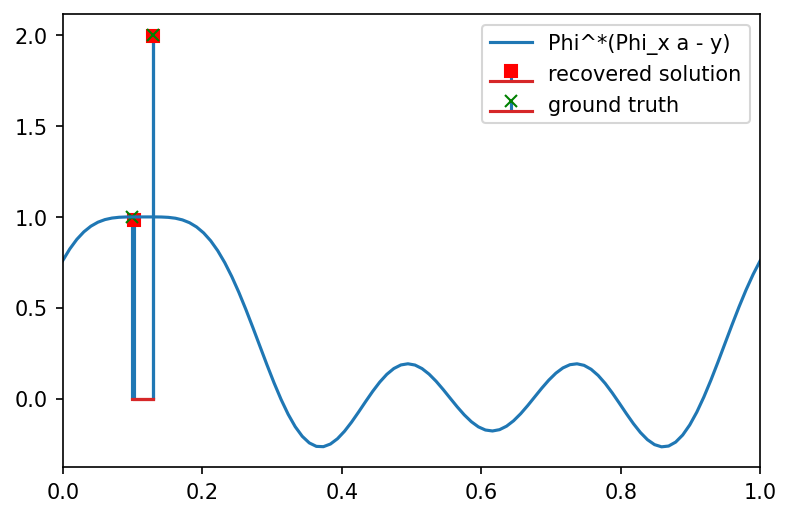

In [9]:
plt.figure(dpi=150)


#plot the recovered solution and the dual solution
Eta = lambda x,p: np.conjugate( Phi(x) ).T  @ p
pk = ( y - Phi(xvals)@avals )/lam
plt.stem(xvals,avals, markerfmt = ('rs'), label='recovered solution')
plt.stem(x,a, markerfmt = ('gx'), label='ground truth')

plt.plot(tgrid,np.real(Eta(tgrid, pk )), label='Phi^*(Phi_x a - y)')
plt.xlim(0,1)
plt.legend()
plt.show()

**References:**

   Bredies, Kristian, and Hanna Katriina Pikkarainen. "Inverse problems in spaces of measures." ESAIM: Control, Optimisation and Calculus of Variations 19.1 (2013): 190-218.  
   Denoyelle, Q., Duval, V., Peyré, G., & Soubies, E. (2019). The sliding Frank–Wolfe algorithm and its application to super-resolution microscopy. Inverse Problems, 36(1), 014001.